Check out the tweek here: https://github.com/swar/nba_api/issues/124#issuecomment-577656182

# Shotcharts Revisited - From NBA Stats to Feature Service in  Less Than 20 Lines of Code!

About two years ago, I wrote about [creating shotcharts in ArcGIS using python and arcpy](https://gavinr.com/2015/11/04/geography-basketball-mapping-nba-shotcharts-arcgis/). In the post, I demonstrated how to scrape the data from [stats.nba.com](http://stats.nba.com/) and create a "shots" feature class from the data. I then shared the resulting shot chart as several web maps in ArcGIS Online. 

What I was unable to do at the time was automate the creation of the feature service and web maps that I shared in that post. Recent enhancements to the ArcGIS API for Python (https://developers.arcgis.com/python/) allow me to automate the process of sharing the "shot" data as a hosted feature service in ArcGIS Online and design web maps using the "shot" data. What I really like is that I can do this with very minimal code! In my precious post, I had to scrape the shot data, create a feature class, add fields to the feature class, and then add the shot data to the feature class. At that point, I would manually create a hosted feature service from the shot feature class. With recent enhancements to the ArcGIS Python API,I can do this all in Python and I can to this in less than 20 lines of code! In this post, I will demonstrate how to to scape data from the NBA statistics site, put it into a spatial dataframe, share the spatial dataframe as a hosted feature service, and design web maps that use the hosted feature service. I will try to do this in as little code as  possible!

## Python Packages

In this post, I will use the ArcGIS Python API, pandas, and requests. I will log into my ArcGIS Online account in order to save the shot data to a hosted feature service.

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.geometry import Geometry, filters
from arcgis.features import GeoAccessor as Ga

import pandas as pd
import requests

from IPython.display import display

gis = GIS("https://www.arcgis.com", "gregbrunner_dbs")

Enter password: ········


## Getting the Shot Data

In my [original post](https://gavinr.com/2015/11/04/geography-basketball-mapping-nba-shotcharts-arcgis/) I looked at shots taken by Russell Westbrook from the 2014-2015 regular season. Here I will look at Russell Westbrook's shots taken during the 2016-2017 regular season. I also showed how to do this with "urllib." Here, I will use requests similar to how Savvas Tjortjoglou does in [How to Create NBA Shot Charts in Python](http://savvastjortjoglou.com/nba-shot-sharts.html). 

In [2]:
player_id= '201566' #Russell Westbrook
season = '2019-20'  #MVP Season of 2016-17
seasontype="Regular+Season" #or use "Playoffs" for shots taken in playoffs

In [3]:
nba_call_url = 'http://stats.nba.com/stats/shotchartdetail?AheadBehind=&CFID=&CFPARAMS=&ClutchTime=&Conference=&ContextFilter=&ContextMeasure=FGM&DateFrom=&DateTo=&Division=&EndPeriod=10&EndRange=28800&GameEventID=&GameID=&GameSegment=&GroupID=&GroupQuantity=5&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&Period=0&PlayerID=%s&PlayerPosition=&PointDiff=&Position=&RangeType=0&RookieYear=&Season=%s&SeasonSegment=&SeasonType=%s&ShotClockRange=&StartPeriod=1&StartRange=0&StarterBench=&TeamID=0&VsConference=&VsDivision=' % (player_id, season, seasontype)
nba_call_url

'http://stats.nba.com/stats/shotchartdetail?AheadBehind=&CFID=&CFPARAMS=&ClutchTime=&Conference=&ContextFilter=&ContextMeasure=FGM&DateFrom=&DateTo=&Division=&EndPeriod=10&EndRange=28800&GameEventID=&GameID=&GameSegment=&GroupID=&GroupQuantity=5&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&Period=0&PlayerID=201566&PlayerPosition=&PointDiff=&Position=&RangeType=0&RookieYear=&Season=2019-20&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StartPeriod=1&StartRange=0&StarterBench=&TeamID=0&VsConference=&VsDivision='

I will form the NBA stats request URL using Russell Westbrook's NBA.com player ID and use requests to get the data.

In [4]:
#url = "https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2019-20&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight="
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}
response = requests.get(url=nba_call_url, headers=headers).json()

In [25]:
#response['resultSets'][0]['rowSet']

I will push the response JSON into a pandas dataframe.

In [6]:
shots = response['resultSets'][0]['rowSet']
headers = response['resultSets'][0]['headers']
shot_df = pd.DataFrame(shots, columns=headers)

In [26]:
shot_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,SHAPE
0,Shot Chart Detail,0021900015,49,201566,Russell Westbrook,1610612745,Houston Rockets,1,9,9,...,24+ ft.,26,-101,243,1,1,20191024,HOU,MIL,"{'x': 101, 'y': 243, 'spatialReference': {'wki..."
1,Shot Chart Detail,0021900015,155,201566,Russell Westbrook,1610612745,Houston Rockets,1,2,33,...,16-24 ft.,17,-65,162,1,0,20191024,HOU,MIL,"{'x': 65, 'y': 162, 'spatialReference': {'wkid..."
2,Shot Chart Detail,0021900015,169,201566,Russell Westbrook,1610612745,Houston Rockets,1,1,40,...,Less Than 8 ft.,2,3,26,1,1,20191024,HOU,MIL,"{'x': -3, 'y': 26, 'spatialReference': {'wkid'..."
3,Shot Chart Detail,0021900015,220,201566,Russell Westbrook,1610612745,Houston Rockets,2,10,50,...,24+ ft.,26,63,256,1,0,20191024,HOU,MIL,"{'x': -63, 'y': 256, 'spatialReference': {'wki..."
4,Shot Chart Detail,0021900015,249,201566,Russell Westbrook,1610612745,Houston Rockets,2,9,29,...,Less Than 8 ft.,3,-20,34,1,0,20191024,HOU,MIL,"{'x': 20, 'y': 34, 'spatialReference': {'wkid'..."


## From DataFrame to SpatialDataFrame

In order to publish the shot data to ArcGIS Online as a shotchart, I will convert the pandas dataframe to an "arcgis"
spatial dataframe. In addition to passing the "shot_df" to "SpatialDataFrame", I will pass the geometries associated with each row in the dataframe.

In [27]:
shot_coords = shot_df.iloc[:,17:19].values.tolist()
#shot_coords

In [9]:
geoms = [Geometry({'x':-r[0], 'y':r[1], 'spatialReference':{'wkid':3857}}) for r in shot_coords]

In [10]:
shot_df.loc[:,'SHAPE'] = geoms

In [11]:
sdf = Ga(shot_df)

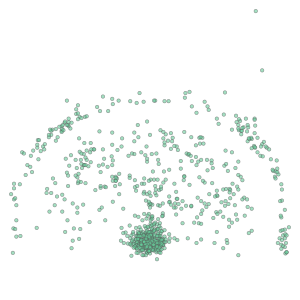

In [12]:
sdf

## From SpatialDataFrame to Service

Now that the shots are in a spatial dataframe, I will publish them to ArcGIS Online.

In [13]:
shot_chart = sdf.to_featurelayer(title="Russell Westbrook in 2019 - 2020 Attempt 2", 
                                tags = ["Russell Westbrook","Basketball"])

Voila! I have the shots as a hosted feature service! It took less than 20 lines of code (including "import" statements) and to go from the NBA stats response to a hosted feature service only took 7 lines!

In [14]:
shot_chart

<Item title:"Russell Westbrook in 2019 - 2020 Attempt 2" type:Feature Layer Collection owner:gregbrunner_dbs>

## From Service to Web Maps

Even though we have the shots as a feature service, we are not done. We can use the Python API to visualize the shots. Using the API for Python will create three maps. One that shows the shots without any renderer. One the that shows the shots symbolized by whether it was made or missed. And one that shows all the shots taken as a heatmap.

For the basketball court, I will use the court feature class that I have in ArcGIS Online.

In [15]:
court_tiles = gis.content.search("Basketball Court", outside_org=False, item_type="Feature")
court_layers = court_tiles[1].layers
court_layers

[<FeatureLayer url:"http://services1.arcgis.com/g2TonOxuRkIqSOFx/arcgis/rest/services/Basketball_Court/FeatureServer/0">,
 <FeatureLayer url:"http://services1.arcgis.com/g2TonOxuRkIqSOFx/arcgis/rest/services/Basketball_Court/FeatureServer/1">]

The court is broken into two feature services: One for the court outline and one for the court lines. I need to add them separately to the web map.

## Shot Locations

Now that I have the basketball court layers and the shots as a feature service, I can display them on my map. I will set the shot chart renderer to "None" in order so that the default point symbology is applied to the "shot_chart" layer.

In [16]:
chart1 = gis.map((0.002,0), zoomlevel=17)
display(chart1)

MapView(layout=Layout(height='400px', width='100%'), zoom=17.0)

In [17]:
chart1.add_layer(court_layers[1])
chart1.basemap='dark-gray'

In [18]:
chart1.add_layer(court_layers[0])
chart1.add_layer(shot_chart)

## Shots Made and Missed

I want to be able to differentiate between shots made and shots missed. I can do that by changing the renderer when I add the "shot_chart" layer to the map. I will use the "ClassedColorRenderer" and apply the class colors based on the values in the "SHOT_MADE_FLAG" field.

In [19]:
chart2 = gis.map((0.002,0), zoomlevel=17)
display(chart2)

MapView(layout=Layout(height='400px', width='100%'), zoom=17.0)

In [20]:
chart2.add_layer(court_layers[1])
chart2.basemap='dark-gray'

In [21]:
chart2.add_layer(court_layers[0])
chart2.add_layer(shot_chart, {"renderer":"ClassedColorRenderer",
               "field_name": "SHOT_MADE_FLAG"})

Shots missed are in dark gray. Shots made are in white. I assume that this is the default "ClassedColorRenderer". I need to do some more investigating to figure out how to apply my desired color map.

## Shots Taken as a Heat Map

I also want to see the shots taken as a heat map. I will use the "HeatmapRenderer" to do that.

In [22]:
chart3 = gis.map((0.002,0), zoomlevel=17)
display(chart3)

MapView(layout=Layout(height='400px', width='100%'), zoom=17.0)

In [23]:
chart3.add_layer(court_layers[1])
chart3.basemap='dark-gray'

In [24]:
chart3.add_layer(court_layers[0])
chart3.add_layer(shot_chart, {"renderer":"HeatmapRenderer",
               "opacity": 0.25})

Again, I assume the orange-to-red color ramp is the default heat map renderer. I need to learn a little bit more about the [API](https://developers.arcgis.com/python/) if I want to change the heat map color ramp.

## Conclusions

I thought it would be fun to revisit my post on mapping shot charts with ArcGIS and Python and see how the code changes with the introduction of the ArcGIS Python API. Using the trick to convert the pandas dataframe to ArcGIS spatial dataframe makes it very easy to go from NBA stats as JSON to a hosted feature service. Iy also reduces the amount of code I need to write significantly. I no longer need to create a feature class with arcpy, add fields to the feature class, then add the data to the feature class. I can now go from the stats as JSON to hosted feature service in only a few lines of code! I am still learning some of the ins-and-outs of the Python API (like applying renderers to the "MapView"), but if you have any questions, don't hesitate to ask!